# LINE-1 IMPLEMENTATION

The original source code from the paper can be found here: [https://github.com/tangjianpku/LINE/tree/master](https://github.com/tangjianpku/LINE/tree/master)

This was also used as help in this implementation.

In [15]:
import random
import time
from tqdm import tqdm
import networkx as nx
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import torch

from sklearn.model_selection import KFold, cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.transforms import RandomLinkSplit

## Creation of a simple test graph

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


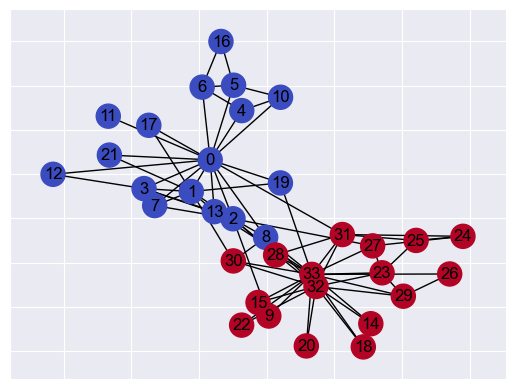

In [2]:
# Creation of a random graph // Upload a graph
G = nx.karate_club_graph()

# Assignment of the labels. Each student belongs to 1 of the 2 possible clubs
clubs = []
print(G.nodes)

for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)
    
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph

# Helper functions

These are the helper functions for LINE-1 algorithm. It uses an alias table that it samples from to make computations more efficient. Addtionally, it uses a negative sampling table for the same reasons.

Moreover, the code used for evaluating embeddings in node classification and link prediction can be found in this section.

In [14]:
def generate_alias(probs):
    """
    Generates an Alias table to sample from based on some probability distribution p
    :param probs: distribution to create the Alias table
    :return: A (Alias table)
    """
    l = len(probs)
    L, H = [], []
    
    for i, p in enumerate(probs):
        if p <= 1/l:
            L.append((i, p))
        else:
            H.append((i, p))
    
    A = []
    while len(L) > 0 and len(H) > 0:
        i, p_i = L.pop()
        h, p_h = H.pop()
        
        A.append((i, h, p_i))
        if p_h - p_i > 1/l:
            H.append((h, p_h - p_i))
        else:
            L.append((h, p_h - p_i))

    # Handling any remaining items
    while len(L) > 0:
        i, p = L.pop()
        A.append((i, i, 1/l))
    
    while len(H) > 0:
        h, p = H.pop()
        A.append((h, h, 1/l))
    return A


def sample_alias(A, l):
    """
    Samples an outcome from the alias table over a distribution p
    :param A: Alias table
    :param l: length of the probability distribution
    :return: an index based on the sampling outcome
    """
    draw = np.random.randint(l)
    i, h, p = A[draw]
    if np.random.rand() < l * p:
        return h
    else:
        return i


def init_neg_table(G, node2int, size):
    """
    Creates a table for the negative sampling of vertices according to vertex degrees 
    :param G: Graph from which to sample
    :param size: size of the table
    :return: Negative sampling table
    """
    degrees_prob = np.zeros(G.number_of_nodes())
    for node, d in G.degree:
        # P_n(v) ∝ d_v ** 0.75 from the paper
        degrees_prob[node2int[node]] = d ** 0.75
    
    Z = np.sum(degrees_prob)
    neg_table = np.zeros(int(size), dtype=np.uint32)
    
    neg_table_id = 0
    for i, p in enumerate(degrees_prob):
        portion_to_fill = np.round((p/Z) * size).astype(int)
        neg_table[neg_table_id:neg_table_id+portion_to_fill] = i
        neg_table_id += portion_to_fill
    return neg_table


# ---- PREDICTION TASKS ----
def node_classification(X, y, n_folds=5):
    """
    5-fold multi-label classification using one-vs-rest logistic regression
    :param X: source embeddings of a graph
    :param y: the labels for each node
    :param n_folds: number of folds for cross-validation
    :return: accuracy, f1 macro score, f1 micro score
    """
    model = LogisticRegression()
    ovr_model = OneVsRestClassifier(model)
    kf = KFold(n_splits=n_folds, shuffle=True)
    eval_scores = {'acc': 'accuracy', 'f1_macro': 'f1_macro', 'f1_micro': 'f1_micro'}
    results = cross_validate(ovr_model, X, y, cv=kf, scoring=eval_scores)
    acc, f1_macro, f1_micro = results['test_acc'].mean(), results['test_f1_macro'].mean(), results['test_f1_micro'].mean()
    return acc, f1_macro, f1_micro


def predict_link(u, v, embeddings):
    """
    Computes the normalized probability for an existing link between two nodes u and v based on the input
    embeddings.
    :param u: a node in the graph
    :param v: a node in the graph
    :param embeddings: trained embeddings
    :return: sigmoid normalized probability for the existence of a link
    """
    embedding1 = embeddings[u]
    embedding2 = embeddings[v]
    
    # Compute inner product (dot product)
    dot_product = np.dot(embedding1, embedding2)

    # Normalize by sigmoid function
    link_probability = 1/(1 + np.exp(-dot_product))
    return link_probability


def link_predictions(embeddings, edges, y_true):
    """
    Computes the ROC-AUC score for a given set of test edges based on the trained embeddings.
    :param embeddings: a models trained embeddings
    :param node2int: a models dictionary to link a node to the correct index for embedding
    :param edges: test edges
    :param y_true: the labels for edges (1=true, 0=false)
    :return: the ROC-AUC score from predictions
    """
    predictions = []
    for edge in edges:
        predictions.append(predict_link(edge[0], edge[1], embeddings))
    return roc_auc_score(y_true, predictions) 


# reference: https://zqfang.github.io/2021-08-12-graph-linkpredict/
def train_test_split_graph(G):
    """
    Splits a Graph into a test and train set randomly to 80-20. The test split is balanced with negative edges sampled from random vertex pairs that have no edges between them. 
    While removing edges randomly, it makes sure that no vertex is isolated.
    :param G: a networkx graph to be split
    :return: the train-test split as torch geometrics graphs
    """
    data = from_networkx(G)
    try:
        data.y = data.group_belonging
    except:
        data.y = data.club  # this only happens with karate club
    data.x = torch.arange(G.number_of_nodes()).unsqueeze(1)
    
    transform = RandomLinkSplit(num_val=0, num_test=0.5, is_undirected=True, add_negative_train_samples=False)
    train_data, _, test_data = transform(data)
    return train_data, test_data


# SILVIA'S METHOD
def multi_label_classification(X, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True)
    micro_f1_scores = []
    macro_f1_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Predictions
        model = OneVsRestClassifier(LogisticRegression())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        micro_f1 = f1_score(y_test, y_pred, average='micro')
        macro_f1 = f1_score(y_test, y_pred, average='macro')

        micro_f1_scores.append(micro_f1)
        macro_f1_scores.append(macro_f1)
    
    # Calculate mean scores over all folds
    mean_micro_f1 = np.mean(micro_f1_scores)
    mean_macro_f1 = np.mean(macro_f1_scores)

    return mean_micro_f1, mean_macro_f1

# Start of the model for Karate Club Network

In [4]:
neg_table_size = 1e8  # default, same as in the original source code
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

node2int = {node: i for i, node in enumerate(G.nodes())}

edges = [[node2int[u], node2int[v]] for u, v in G.edges()]
edges_prob = np.array([G[u][v].get("weight", 1) for u, v in G.edges()])
edges_prob = edges_prob/np.sum(edges_prob)

# Create sampling tables for the algorithm
neg_table = init_neg_table(G, node2int, neg_table_size)
alias_table = generate_alias(edges_prob)
print('Num nodes:', num_nodes, 'Edges:', num_edges)

Num nodes: 34 Edges: 78


In [5]:
# hyperparameters from the paper
dim = 128
alpha = 0.025
neg_samples = 5
T = 1e6

np.random.seed(42)
# starting embedding, uniform [-0.5, 0.5]
init_embeddings = (np.random.random((num_nodes, dim)) - 0.5)/dim

In [6]:
def update(u_i, u_j, alpha, acc_gradient, local_label):
    """
    The update equation for the SGD in the LINE-1 algorithm
    :param u_i: source representation for vertex i
    :param u_j: source representation for vertex j
    :param alpha: learning rate
    :param acc_gradient: accumulated gradient
    :param local_label: label in the local graph (1=connected, 0=not connected)
    :return: 
    """
    f_line = 1/(1 + np.exp(-(u_i @ u_j)))  # sigmoid
    g = (local_label - f_line) * alpha
    
    acc_gradient += g * u_j
    u_j += g * u_i
    return 


def train_line(embeddings, alpha_0, num_samples, edges, alias_table, neg_samples, neg_table):
    """
    Trains a LINE-1 algorithm embeddings via Edge Sampling with a minibatch size of 1
    :param embeddings: vertex embeddings to train
    :param alpha_0: starting learning rate
    :param num_samples: number of edge samples used for training
    :param edges: edges in the graph
    :param alias_table: alias table to sample edges
    :param neg_samples: amount of negative samples
    :param neg_table: table to use for negative samples 
    :return: trained embeddings
    """
    trained_embeddings = embeddings.copy()
    
    start = time.time()
    alpha = alpha_0
    
    for i in tqdm(range(int(num_samples))):
        if i > 0:
            alpha = alpha_0*(1-i/num_samples)
        
        edge = sample_alias(alias_table, num_edges)
        u, v = edges[edge]
        
        acc_gradient = np.zeros(dim)
        update(trained_embeddings[u], trained_embeddings[v], alpha, acc_gradient, local_label=1)
        
        for k in range(neg_samples):
            v = random.choice(neg_table)
            update(trained_embeddings[u], trained_embeddings[v], alpha, acc_gradient, local_label=0)
        
        trained_embeddings[u] += acc_gradient
    print(f"Training time: {time.time() - start}s")
    return trained_embeddings

In [8]:
embeddings = train_line(init_embeddings, alpha, T, edges, alias_table, neg_samples, neg_table)
norm_embed = normalize(embeddings)
norm_embed

100%|██████████| 1000000/1000000 [00:24<00:00, 41322.25it/s]

Training time: 24.219100952148438s


array([[ 0.00823505,  0.13717892,  0.08407578, ..., -0.1156751 ,
        -0.08785803, -0.04872237],
       [ 0.02846845,  0.0141502 ,  0.11430858, ..., -0.05913688,
        -0.19679494, -0.01355332],
       [ 0.03013776,  0.0395401 ,  0.10177882, ...,  0.04407838,
        -0.06701286,  0.04809669],
       ...,
       [ 0.03702577, -0.10309879, -0.05142961, ...,  0.19144263,
        -0.00998952, -0.00372646],
       [-0.0427767 , -0.08185791, -0.09965335, ..., -0.05694654,
         0.16095217, -0.01283852],
       [ 0.11431638, -0.03991154, -0.07062563, ...,  0.12532351,
        -0.03888756,  0.08235593]])

In [9]:
def get_node_labels(G):
    """
    Input:
      G: Graph
    Output:
      labels: Array with labels. Each position of the array will correspond to the groups of id = index + 1
    """
    labels = []
    for n in G.nodes:
        l = G.nodes[n].get('club')
        labels.append(l)
    return labels

In [10]:
# Encode the labels for each node
labels = get_node_labels(G)
ls = np.zeros(num_nodes)
for i, label in enumerate(labels):
    if label == 'Mr. Hi':
        ls[i] = 0
    else:
        ls[i] = 1

**NODE PREDICTION**:

In [19]:
# my method
acc, f1_macro, f1_micro = node_classification(norm_embed, ls)
print('F1 macro:', f1_macro, 'F1 micro:', f1_micro)

F1 macro: 0.926984126984127 F1 micro: 0.9380952380952381


# Creation of LINE-1 class based on the previous code

In [3]:
class Line:
    def __init__(self, G, dim, alpha, neg_samples, num_edge_samples):
        """
        Initializes a LINE-1 embedding algorithm
        :param G: Graph as a networkx object
        :param dim: dimension of embeddings
        :param alpha: learning rate
        :param neg_samples: number of negative samples in training
        :param num_edge_samples: number of edge samples used in training
        """
        self.neg_table_size = 1e8  # default, same as in the original source code
        self.num_nodes = G.number_of_nodes()
        self.num_edges = G.number_of_edges()
        self.node2int = {node: i for i, node in enumerate(G.nodes())}  # dictionary for easy access in arrays
        
        # Compute the probability weights for each edge
        self.edges = [[self.node2int[u], self.node2int[v]] for u, v in G.edges()]
        edges_prob = np.array([G[u][v].get("weight", 1) for u, v in G.edges()])
        self.edges_prob = edges_prob/np.sum(edges_prob)
        
        # Create sampling tables for the algorithm
        self.neg_table = init_neg_table(G, self.node2int, self.neg_table_size)
        self.alias_table = generate_alias(self.edges_prob)
        
        # hyperparameters
        self.dim = dim
        self.alpha_0 = alpha
        self.neg_samples = neg_samples
        self.T = num_edge_samples
        
        self.embeddings = (np.random.random((self.num_nodes, self.dim)) - 0.5)/self.dim
        
    def update(self, u_i, u_j, alpha, acc_gradient, local_label):
        """
        The update equation for the SGD in the LINE-1 algorithm
        :param u_i: source representation for vertex i
        :param u_j: source representation for vertex j
        :param acc_gradient: accumulated gradient
        :param local_label: label in the local graph (1=connected, 0=not connected)
        :return: 
        """
        f_line = 1/(1 + np.exp(-(u_i @ u_j)))  # sigmoid
        g = (local_label - f_line) * alpha
        
        acc_gradient += g * u_j
        u_j += g * u_i
        return 

    def train_line(self, file_name):
        """
        Trains a LINE-1 algorithm embeddings via Edge Sampling with a minibatch size of 1
        :return: trained embeddings
        """
        
        start = time.time()
        alpha = self.alpha_0
        for i in tqdm(range(int(self.T))):
            if i > 0:
                alpha = self.alpha_0*(1-i/self.T)
            
            edge = sample_alias(self.alias_table, self.num_edges)
            u, v = self.edges[edge]
            
            acc_gradient = np.zeros(self.dim)
            self.update(self.embeddings[u], self.embeddings[v], alpha, acc_gradient, local_label=1)
            
            for k in range(self.neg_samples):
                v = random.choice(self.neg_table)
                self.update(self.embeddings[u], self.embeddings[v], alpha, acc_gradient, local_label=0)
            
            self.embeddings[u] += acc_gradient
        
        norm_trained_embeddings = normalize(self.embeddings)
        np.save(f'./embeddings/{file_name}.npy', norm_trained_embeddings)
        self.embeddings = norm_trained_embeddings
        print(f"Training time: {time.time() - start}s")
        return norm_trained_embeddings
    

**LINK PREDICTION FOR KARATE CLUB:**

In [25]:
# LINK PREDICTION
train_data, test_data = train_test_split_graph(G)

# Create graph from the train split in networkx format
train_G = nx.Graph()
train_G.add_nodes_from(train_data.x.squeeze().numpy())
# Add edges to the graph
train_G.add_edges_from(train_data.edge_label_index.numpy().T)

model = Line(train_G, dim, alpha, neg_samples, T)
embeddings = model.train_line('test')

100%|██████████| 1000000/1000000 [00:24<00:00, 41367.23it/s]

Training time: 24.176151037216187s


In [26]:
# Set up test data
test_edges = test_data.edge_label_index.numpy().T
y_true = test_data.edge_label.numpy()

print('ROC-AUC:', link_predictions(embeddings, test_edges, y_true))

ROC-AUC: 0.48


# BlogCatalog Experiments

In [5]:
# Load the data
edges_path = './BlogCatalog-dataset/data/edges.csv'
nodes_path = './BlogCatalog-dataset/data/nodes.csv'
groups_path = './BlogCatalog-dataset/data/groups.csv'
group_edges_path = './BlogCatalog-dataset/data/group-edges.csv'

nodes_id = pd.read_csv(nodes_path, header=None, names=['id'])
groups_id = pd.read_csv(groups_path, header=None, names=['group'])
edges = pd.read_csv(edges_path, header=None, names=['id_1', 'id_2'])
user_group_membership = pd.read_csv(group_edges_path, header=None, names=['id', 'group'])

In [6]:
# Create a graph
G_BC = nx.Graph()

# Add nodes to the graph
G_BC.add_nodes_from(nodes_id['id'])

# Add edges to the graph
G_BC.add_edges_from(edges[['id_1', 'id_2']].values)

In [7]:
# Create a dictionary to store groups for each ID
group_dict = {}

# Populate the group_dict
for _, row in user_group_membership.iterrows():
    user_id = row['id']
    group_id = row['group']

    # Check if the user_id is already in the dictionary
    if user_id in group_dict:
        group_dict[user_id].append(group_id)
    else:
        group_dict[user_id] = [group_id]

# Add group labels to the nodes
for user_id, groups in group_dict.items():
    nx.set_node_attributes(G_BC, {user_id: groups}, 'group_belonging')

# Print basic graph information
print("Number of nodes:", G_BC.number_of_nodes(), ' | ', "Number of edges:", G_BC.number_of_edges())

Number of nodes: 10312  |  Number of edges: 333983


In [8]:
# Find and preprocess labels for the graph
labels = []
for n in G_BC.nodes:
    l = G_BC.nodes[n].get('group_belonging')
    labels.append(l)

mlb = MultiLabelBinarizer()
preprocessed_labels = mlb.fit_transform(labels)

In [69]:
# hyperparameters from the paper
dim = 128
alpha = 0.025
neg_samples = 5
T = 1e9

model = Line(G_BC, dim, alpha, neg_samples, T)

In [70]:
# Train embeddings
embeddings_model = model.train_line('blog_catalog')

100%|██████████| 1000000000/1000000000 [6:51:10<00:00, 40534.59it/s] 

Training time: 24670.298993110657s


In [9]:
# Load embeddings
embeddings_model = np.load('./embeddings/blog_catalog.npy')

**Node Classification:**

In [84]:
N = 5
f1_macros, f1_micros = np.zeros(N), np.zeros(N)
for i in range(N):
    _, f1_macro, f1_micro = node_classification(embeddings_model, preprocessed_labels)
    f1_macros[i] = f1_macro
    f1_micros[i] = f1_micro
    print(f'Shuffle {i+1} --', 'F1 macro:', f1_macro, 'F1 micro:', f1_micro)

Shuffle 1 -- F1 macro: 0.13017053259341307 F1 micro: 0.2820697044531669
Shuffle 2 -- F1 macro: 0.13326918522823067 F1 micro: 0.28435586594060624
Shuffle 3 -- F1 macro: 0.13090842578101675 F1 micro: 0.28251294671104815
Shuffle 4 -- F1 macro: 0.13240513704466383 F1 micro: 0.2822681394728502
Shuffle 5 -- F1 macro: 0.13221650178836997 F1 micro: 0.2826689728522681


In [85]:
print('-----  Final results: -----')
print('F1 macro:', np.mean(f1_macros), 'F1 micro:', np.mean(f1_micros))

-----  Final results: -----
F1 macro: 0.13179395648713885 F1 micro: 0.28277512588598797


**Link Prediction:**

In [16]:
N = 5
roc_auc_scores = np.zeros(N)
for i in range(N):
    train_data, test_data = train_test_split_graph(G_BC)

    # Prepare edges
    test_edges = test_data.edge_label_index.numpy().T
    y_true = test_data.edge_label.numpy()
    
    score = link_predictions(embeddings_model, test_edges, y_true)
    roc_auc_scores[i] = score
    print(f'Shuffle {i+1} --', 'ROC-AUC:', roc_auc_score)

Shuffle 1 -- ROC-AUC: 0.8322549740413538
Shuffle 2 -- ROC-AUC: 0.8312477973232344
Shuffle 3 -- ROC-AUC: 0.8317219786259195
Shuffle 4 -- ROC-AUC: 0.8322335444664115
Shuffle 5 -- ROC-AUC: 0.8315037324345762


In [17]:
print('-----  Final results: -----')
print('ROC-AUC:', np.mean(roc_auc_scores))

-----  Final results: -----
ROC-AUC: 0.8317924053782992


In [ ]:
print('-----  Final results: -----')
print('ROC-AUC:', np.mean(roc_auc_scores))

# PubMed Experiments

In [21]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/PubMed', name='PubMed')
data = dataset[0]

In [20]:
# convert to networkx
G_pubmed = to_networkx(data)
G_pubmed = G_pubmed.to_undirected()

# Create a dictionary to store groups for each ID
group_dict = {}

# Populate the group_dict
for i in range(len(data.y)):
    user_id = i
    group_id = int(data.y[i].numpy())

    # Check if the user_id is already in the dictionary
    if user_id in group_dict:
        if type(group_id) == int:
            group_dict[user_id].append(group_id)
        else:
            group_dict[user_id].extend(group_id)
    else:
        if type(group_id) == int:
            group_dict[user_id] = [group_id]
        else:
             group_dict[user_id] = list(group_id)

# Add group labels to the nodes
for user_id, groups in group_dict.items():
    nx.set_node_attributes(G_pubmed, {user_id: groups}, 'group_belonging')

# Print basic graph information
print("Number of nodes:", G_pubmed.number_of_nodes(), ' | ', "Number of edges:", G_pubmed.number_of_edges())

Number of nodes: 19717  |  Number of edges: 44324


In [22]:
# Find and preprocess labels for the graph
labels = []
for n in G_pubmed.nodes:
    l = G_pubmed.nodes[n].get('group_belonging')
    labels.append(l)

mlb = MultiLabelBinarizer()
preprocessed_labels = mlb.fit_transform(labels)

In [ ]:
# hyperparameters from the paper
dim = 128
alpha = 0.025
neg_samples = 5
T = 1e9

model_pm = Line(G_pubmed, dim, alpha, neg_samples, T)

In [ ]:
# Train embeddings
embeddings_model_pm = model_pm.train_line('pubmed')

For some reason the training process did not produce output here. However, the model was trained for 1 billion edge samples and approx. 7 hours like the others. The trained embeddings of the model have been stored in the embeddings folder with the rest.

In [23]:
# Load embeddings
embeddings_model_pm = np.load('./embeddings/pubmed.npy')

**Node Classification:**

In [24]:
N = 5
f1_macros, f1_micros = np.zeros(N), np.zeros(N)
for i in range(N):
    _, f1_macro, f1_micro = node_classification(embeddings_model_pm, preprocessed_labels)
    f1_macros[i] = f1_macro
    f1_micros[i] = f1_micro
    print(f'Shuffle {i+1} --', 'F1 macro:', f1_macro, 'F1 micro:', f1_micro)

Shuffle 1 -- F1 macro: 0.584720816700087 F1 micro: 0.6090905586327772
Shuffle 2 -- F1 macro: 0.5834123957665296 F1 micro: 0.6075628553713592
Shuffle 3 -- F1 macro: 0.5858065457451254 F1 micro: 0.6095841873443479
Shuffle 4 -- F1 macro: 0.5852300553174254 F1 micro: 0.6089855115098677
Shuffle 5 -- F1 macro: 0.5866945366373131 F1 micro: 0.6105517506204459


In [25]:
print('-----  Final results: -----')
print('F1 macro:', np.mean(f1_macros), 'F1 micro:', np.mean(f1_micros))

-----  Final results: -----
F1 macro: 0.5851728700332961 F1 micro: 0.6091549726957595


**Link Prediction:**

In [26]:
N = 5
roc_auc_scores = np.zeros(N)
for i in range(N):
    train_data, test_data = train_test_split_graph(G_pubmed)

    # Prepare edges
    test_edges = test_data.edge_label_index.numpy().T
    y_true = test_data.edge_label.numpy()
    
    score = link_predictions(embeddings_model_pm, test_edges, y_true)
    roc_auc_scores[i] = score
    print(f'Shuffle {i+1} --', 'ROC-AUC:', roc_auc_score)

Shuffle 1 -- ROC-AUC: 0.865288980379858
Shuffle 2 -- ROC-AUC: 0.8635653650180004
Shuffle 3 -- ROC-AUC: 0.8626191021979644
Shuffle 4 -- ROC-AUC: 0.865102403553699
Shuffle 5 -- ROC-AUC: 0.8669947337358243


In [27]:
print('-----  Final results: -----')
print('ROC-AUC:', np.mean(roc_auc_scores))

-----  Final results: -----
ROC-AUC: 0.8647141169770693


# Cora Experiments

In [28]:
from torch_geometric.datasets import CitationFull
dataset = CitationFull(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [29]:
# convert to networkx
G_cora = to_networkx(data)
G_cora = G_cora.to_undirected()

# Create a dictionary to store groups for each ID
group_dict = {}

# Populate the group_dict
for i in range(len(data.y)):
    user_id = i
    group_id = int(data.y[i].numpy())

    # Check if the user_id is already in the dictionary
    if user_id in group_dict:
        if type(group_id) == int:
            group_dict[user_id].append(group_id)
        else:
            group_dict[user_id].extend(group_id)
    else:
        if type(group_id) == int:
            group_dict[user_id] = [group_id]
        else:
             group_dict[user_id] = list(group_id)

# Add group labels to the nodes
for user_id, groups in group_dict.items():
    nx.set_node_attributes(G_cora, {user_id: groups}, 'group_belonging')

# Print basic graph information
print("Number of nodes:", G_cora.number_of_nodes(), ' | ', "Number of edges:", G_cora.number_of_edges())

Number of nodes: 19793  |  Number of edges: 63421


In [34]:
# Find and preprocess labels for the graph
labels = []
for n in G_BC.nodes:
    l = G_BC.nodes[n].get('group_belonging')
    labels.append(l)

mlb = MultiLabelBinarizer()
preprocessed_labels = mlb.fit_transform(labels)

In [32]:
# hyperparameters from the paper
dim = 128
alpha = 0.025
neg_samples = 5
T = 1e9

model = Line(G_cora, dim, alpha, neg_samples, T)

In [33]:
embeddings_model = model.train_line('cora')

100%|██████████| 1000000000/1000000000 [7:02:43<00:00, 39427.18it/s]  

Training time: 25363.266119003296s


In [ ]:
# Load embeddings
embeddings_model_cora = np.load('./embeddings/cora.npy')

**Node Classification:**

In [35]:
N = 5
f1_macros, f1_micros = np.zeros(N), np.zeros(N)
for i in range(N):
    _, f1_macro, f1_micro = node_classification(embeddings_model_cora, preprocessed_labels)
    f1_macros[i] = f1_macro
    f1_micros[i] = f1_micro
    print(f'Shuffle {i+1} --', 'F1 macro:', f1_macro, 'F1 micro:', f1_micro)

Shuffle 1 -- F1 macro: 0.32989731612247497 F1 micro: 0.43609715291880846
Shuffle 2 -- F1 macro: 0.33266220261992957 F1 micro: 0.43743492506223836
Shuffle 3 -- F1 macro: 0.33242125821771956 F1 micro: 0.4367266778821719
Shuffle 4 -- F1 macro: 0.3324039384675669 F1 micro: 0.43625996777262205
Shuffle 5 -- F1 macro: 0.3358879504993825 F1 micro: 0.4384843277704064


In [36]:
print('-----  Final results: -----')
print('F1 macro:', np.mean(f1_macros), 'F1 micro:', np.mean(f1_micros))

-----  Final results: -----
F1 macro: 0.33265453318541466 F1 micro: 0.4370006102812495


**Link Prediction:**

In [39]:
N = 5
roc_auc_scores = np.zeros(N)
for i in range(N):
    train_data, test_data = train_test_split_graph(G_pubmed)

    # Prepare edges
    test_edges = test_data.edge_label_index.numpy().T
    y_true = test_data.edge_label.numpy()
    
    score = link_predictions(embeddings_model_pm, test_edges, y_true)
    roc_auc_scores[i] = score
    print(f'Shuffle {i+1} --', 'ROC-AUC:', score)

Shuffle 1 -- ROC-AUC: 0.9252773225425427
Shuffle 2 -- ROC-AUC: 0.9247955608423507
Shuffle 3 -- ROC-AUC: 0.9256148629356571
Shuffle 4 -- ROC-AUC: 0.9247566080216278
Shuffle 5 -- ROC-AUC: 0.927311955029223


In [41]:
print('-----  Final results: -----')
print('ROC-AUC:', np.mean(roc_auc_scores))

-----  Final results: -----
ROC-AUC: 0.9255512618742804
